<a href="https://colab.research.google.com/github/faqihz/EA/blob/master/Skin_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Skin Cancer Detection Using Deep Learning Techniques

## Dependencies and imports

In [ ]:
!pip3 install -q pandas
!pip3 install http://download.pytorch.org/whl/cu92/torch-0.4.1-cp36-cp36m-linux_x86_64.whl
!pip3 install torchvision  
!pip3 install livelossplot

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from __future__ import print_function, division
import pandas as pd
import torchvision,torch, os, shutil, time, copy
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from torchvision import utils,datasets, models
from torchvision import transforms
from torch.optim import lr_scheduler

from livelossplot import PlotLosses
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


## Util Class

In [ ]:
class Util(Dataset):
    """Skin Cancer dataset."""

    def __init__(self, xlsx_file, root_dir, transform=None):
        """
        Args:
            xlsx_file (string): Path to the xlsx file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_frame = pd.read_excel(xlsx_file)

    def create_directory(self, directory):
        if not os.path.exists(directory):
            print('Create directory:' + str(directory))
            os.makedirs(directory)
        
    def get_label(self, n):
        matrix = df.iloc[n, 0:].as_matrix()
        name_of_image = matrix[0]
        label_of_image = None
        if (matrix[2] == 'X'):
                label_of_image = 'Common Nevus'
        #Atypical Nevus can be interpreted as common nevus (it's not cancer)
        elif(matrix[3] == 'X'):
                label_of_image = 'Common Nevus'
        elif(matrix[4] == 'X'):
                label_of_image = 'Melanoma'
        return name_of_image,label_of_image
        
    def __len__(self):
        return len(self.image_frame)

    def __getitem__(self, idx):
        
        img_name, label = self.get_label(idx)
        image = io.imread(os.path.join(self.root_dir+img_name+'/'+img_name+'_Dermoscopic_Image', img_name + '.bmp'))
        sample = {'image': image, 'label': label, 'img_name': img_name}
    
        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
df = pd.read_excel("PH2_dataset.xlsx")
ph2_dataset = Util(xlsx_file='PH2_dataset.xlsx',
                                    root_dir='PH2 Dataset images/')

root_directory = '/home/naroh/TFG/dataset/'
sub_directory_common_nevus = '/home/naroh/TFG/dataset/commonnevus'
sub_directory_melanoma = '/home/naroh/TFG/dataset/melanoma'

ph2_dataset.create_directory(root_directory)
ph2_dataset.create_directory(sub_directory_common_nevus)
ph2_dataset.create_directory(sub_directory_melanoma)

for i in range(len(ph2_dataset)):
    sample = ph2_dataset[i]
    print(i, sample['image'].shape, sample['label'])
    img_name = sample['img_name']
    label = sample['label']
    old_name = os.path.join('PH2 Dataset images/'+img_name+'/'+img_name+'_Dermoscopic_Image', img_name + '.bmp')
    
    if(label == 'Common Nevus'):
        new_name = os.path.join(sub_directory_common_nevus + '/' + img_name + '.bmp')
        shutil.move(old_name, new_name)
        print('Move image' + old_name + 'to the Common Nevus directory')
    
    elif(label == 'Melanoma'):
        new_name = os.path.join(sub_directory_melanoma + '/' + img_name + '.bmp')
        shutil.move(old_name, new_name)
        print('Move image' + old_name + 'to the Melanoma directory')
    

## Data Loader

In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/My Drive/ISIC Dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
    

{'train': 4000, 'test': 400}
cuda:0


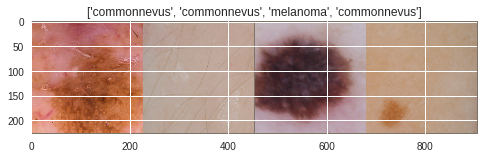

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Train the model and visualize results

In [ ]:
# Training the model

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    liveloss = PlotLosses()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if(phase == 'train'):
                avg_loss = epoch_loss
                avg_accuracy = epoch_acc
            
            elif(phase == 'test'):
                avg_loss_val = epoch_loss
                avg_accuracy_val = epoch_acc
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        
        liveloss.update({'log loss': avg_loss,
                         'val_log loss': avg_loss_val,
                         'accuracy': avg_accuracy,
                         'val_accuracy': avg_accuracy_val})
        liveloss.draw()
        
    time_elapsed = time.time() - since
    

 

    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [ ]:
# Visualizing the model predictions
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                print('predicted: {}'.format(class_names[preds[j]]))
                print('real: {}'.format(class_names[labels.cpu().data[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the Convolutional Network

Instead of random initializaion, we initialize the network with a pretrained network, like the one that is trained on imagenet 1000 dataset. Rest of the training looks as usual.

** Convolution Network as fixed feature extractor: **

Here, we will freeze the weights for all of the network except that of the final fully connected layer. This last fully connected layer is replaced with a new one with random weights and only this layer is trained.

### Resnet-50 - SGD


In [ ]:
# Finetuning the convnet
# Load a pretrained model and reset final fully connected layer.
# Resnet with 50 layers
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)


# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:01<00:00, 96400618.76it/s]


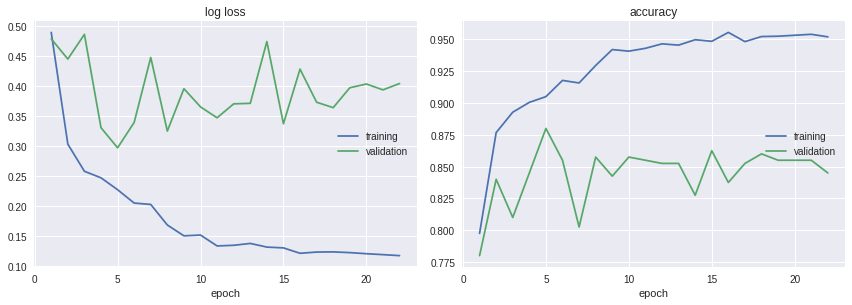

log loss:
training   (min:    0.117, max:    0.489, cur:    0.117)
validation (min:    0.297, max:    0.486, cur:    0.404)

accuracy:
training   (min:    0.797, max:    0.956, cur:    0.952)
validation (min:    0.780, max:    0.880, cur:    0.845)
Training complete in 445m 28s
Best val Acc: 0.880000


In [ ]:
#Train and evaluate
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=22)

torch.save(model_ft, 'resnet-50')

predicted: commonnevus
real: commonnevus


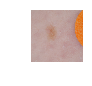

predicted: melanoma
real: melanoma


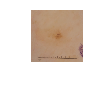

predicted: melanoma
real: melanoma


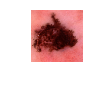

predicted: melanoma
real: melanoma


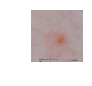

predicted: melanoma
real: melanoma


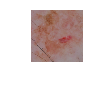

predicted: melanoma
real: melanoma


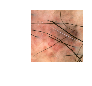

predicted: commonnevus
real: commonnevus


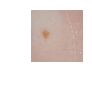

predicted: melanoma
real: melanoma


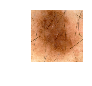

predicted: melanoma
real: melanoma


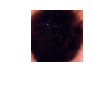

predicted: commonnevus
real: commonnevus


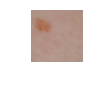

In [ ]:
#Visualize the model
visualize_model(model_ft)

### Resnet 18

In [ ]:
# Finetuning the convnet
# Load a pretrained model and reset final fully connected layer.
# ResNet with 18 layers
model_ft_18 = models.resnet18(pretrained=True)
num_ftrs = model_ft_18.fc.in_features
model_ft_18.fc = nn.Linear(num_ftrs, 2)

model_ft_18 = model_ft_18.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft_18.parameters(), lr=0.01, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

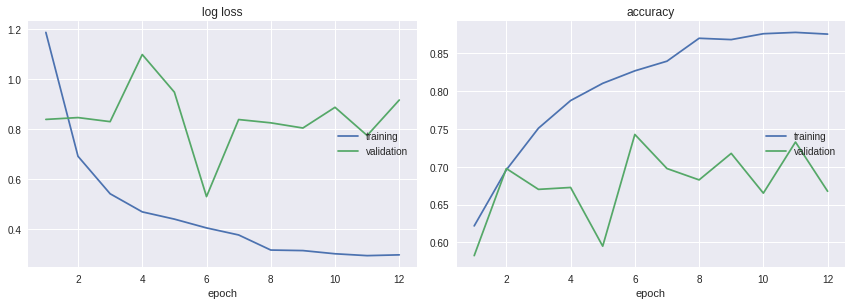

log loss:
training   (min:    0.294, max:    1.186, cur:    0.297)
validation (min:    0.530, max:    1.098, cur:    0.916)

accuracy:
training   (min:    0.622, max:    0.877, cur:    0.875)
validation (min:    0.583, max:    0.743, cur:    0.667)
Training complete in 237m 39s
Best val Acc: 0.742500


In [ ]:
#Train and evaluate
model_ft_18 = train_model(model_ft_18, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=12)
torch.save(model_ft_18, 'resnet-18')

In [ ]:
#Visualize the model
visualize_model(model_ft_18)

### Densenet

In [ ]:

# Finetuning the convnet
# Load a pretrained model and reset final fully connected layer.
# DenseNet with 121 layers
model_conv = torchvision.models.densenet121(pretrained='imagenet')
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_conv.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.torch/models/densenet121-a639ec97.pth
100%|██████████| 32342954/32342954 [00:01<00:00, 25550166.42it/s]


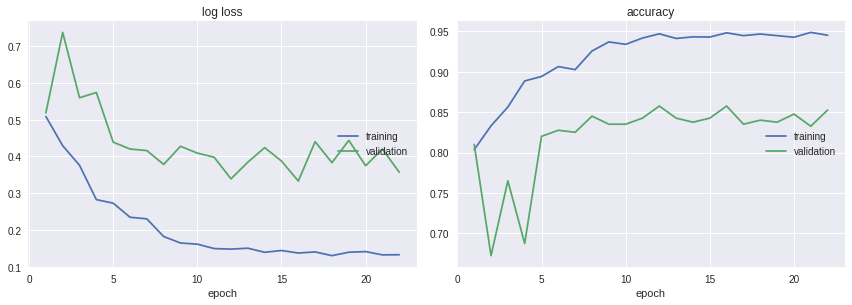

log loss:
training   (min:    0.131, max:    0.508, cur:    0.133)
validation (min:    0.333, max:    0.737, cur:    0.357)

accuracy:
training   (min:    0.803, max:    0.949, cur:    0.945)
validation (min:    0.672, max:    0.858, cur:    0.853)
Training complete in 432m 57s
Best val Acc: 0.857500


In [ ]:
 #Train and evaluate
model_conv = train_model(model_conv, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=22)
torch.save(model_conv, 'densenet121')

In [ ]:
#Visualize the model
visualize_model(model_conv)

## Evaluate models

In [ ]:
# Get results for confusion matrix
def get_results(model, num_images=400):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                prediction = class_names[preds[j]]
                real = class_names[labels.cpu().data[j]]
                if(prediction == 'melanoma' and real == 'melanoma'):
                  TP = TP + 1
                elif(prediction =='commonnevus' and real == 'commonnevus'):
                  TN = TN + 1
                elif(prediction =='commonnevus' and real == 'melanoma'):
                  FN = FN + 1
                elif(prediction == 'melanoma' and real == 'commonnevus'):
                  FP = FP + 1
                  
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return TP, TN, FN, FP
        model.train(mode=was_training)

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
  
  import matplotlib.pyplot as plt
  import numpy as np
  import itertools

  accuracy = np.trace(cm) / float(np.sum(cm))
  misclass = 1 - accuracy

  if cmap is None:
      cmap = plt.get_cmap('Blues')

  plt.figure(figsize=(8, 6))
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()

  if target_names is not None:
      tick_marks = np.arange(len(target_names))
      plt.xticks(tick_marks, target_names, rotation=45)
      plt.yticks(tick_marks, target_names)

  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


  thresh = cm.max() / 1.5 if normalize else cm.max() / 2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      if normalize:
          plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")
      else:
          plt.text(j, i, "{:,}".format(cm[i, j]),
                   horizontalalignment="center",
                   color="white" if cm[i, j] > thresh else "black")


  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
  plt.show()

In [ ]:
#Load the model in memory
model = torch.load('/content/drive/My Drive/ISIC-Model-Resnet50', map_location={'cuda:0': 'cpu'})
model.to('cuda:0')



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

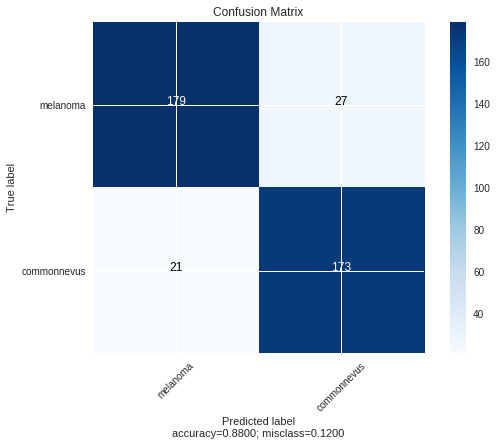

In [ ]:
TP, TN, FN, FP = get_results(model)
plot_confusion_matrix(cm           = np.array([[ TP,  FP],
                                              [  FN,  TN]]), 
                      normalize    = False,
                      target_names = ['melanoma', 'commonnevus'],
                      title        = "Confusion Matrix")

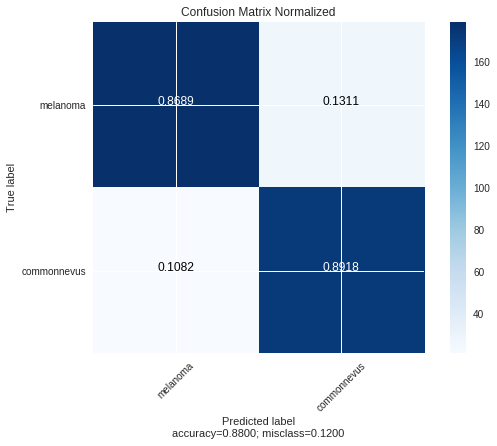

In [ ]:
plot_confusion_matrix(cm           = np.array([[ TP,  FP],
                                              [  FN,  TN]]), 
                      normalize    = True,
                      target_names = ['melanoma', 'commonnevus'],
                      title        = "Confusion Matrix Normalized")